# CelebA-Spoof for Anti Spoofing using MobileNetV2

Muhammad Adisatriyo Pratama - May 2021
____________________
## Face Antispoofing using Celeb-A Spoof dataset with TensorFlow

CelebA-Spoof Dataset Reference:
- https://github.com/Davidzhangyuanhan/CelebA-Spoof

```script
@inproceedings{CelebA-Spoof,
  title={CelebA-Spoof: Large-Scale Face Anti-Spoofing Dataset with Rich Annotations},
  author={Zhang, Yuanhan and Yin, Zhenfei and Li, Yidong and Yin, Guojun and Yan, Junjie and Shao, Jing and Liu, Ziwei},
  booktitle={European Conference on Computer Vision (ECCV)},
  year={2020}
}
```

## Use GPU

In [1]:
!nvidia-smi

Tue Apr 27 22:47:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.11       Driver Version: 466.11       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:1F:00.0  On |                  N/A |
| 46%   37C    P8     2W / 130W |    497MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Library

In [2]:
# basic library
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline

C:\Users\Roy\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Roy\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Roy\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Dataset Preparation

In [3]:
data_path = 'e:/skripsi/face-anti-spoof-celeba-spoof/dataset/'
TRAIN_DIR = data_path + 'train/'
TEST_DIR = data_path + 'test/'

live_path_train = TRAIN_DIR + "real/"
spoof_path_train = TRAIN_DIR + "spoof/"

live_train = os.listdir(live_path_train)
spoof_train = os.listdir(spoof_path_train)

In [4]:
print('Training Data:')
n_real = len(os.listdir(live_path_train))
n_spoof = len(os.listdir(spoof_path_train))
n_real, n_spoof

Training Data:


(162462, 331943)

## Sample Real and Spoof Images

In [5]:
import cv2


def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

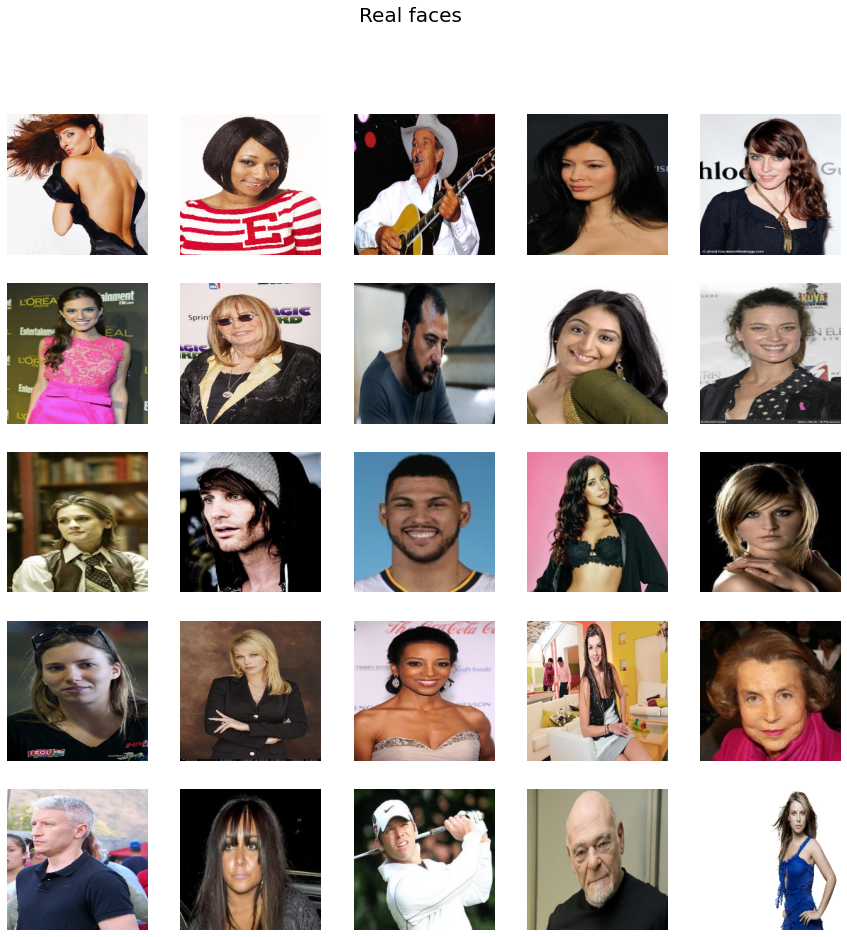

In [6]:
fig = plt.figure(figsize=(15, 15))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(live_path_train + live_train[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

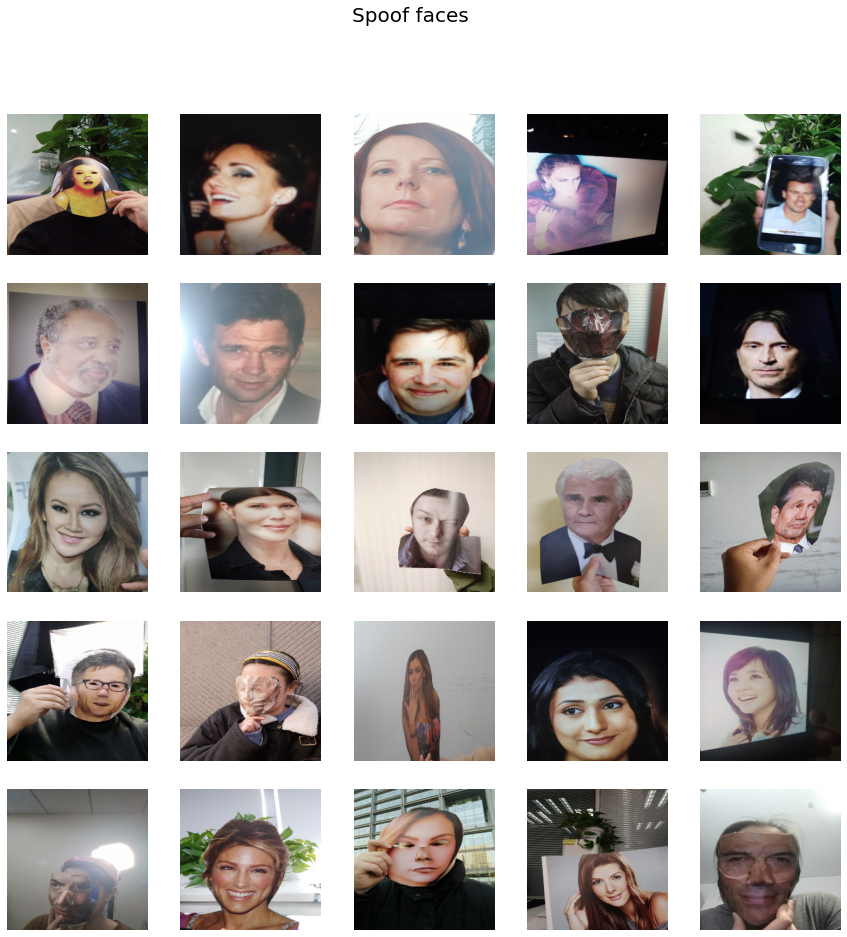

In [7]:
fig = plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(spoof_path_train + spoof_train[i]), cmap='gray')
    plt.suptitle("Spoof faces",fontsize=20)
    plt.axis('off')

plt.show()

## Preprocessing

In [8]:
# tensorflow library
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.1
Hub version:  0.11.0
GPU is available


In [9]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Variable

In [10]:
INIT_LR = 1e-4
ALPHA = 1e-5
BATCH_SIZE = 200
IMG_SHAPE = (128, 128, 3)
EPOCHS = 10
SAMPLE_QTD = 1.0
RANDOM_STATE = 42

In [11]:
from keras.preprocessing.image import ImageDataGenerator


val_share = 0.1

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_share,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 444965 images belonging to 2 classes.
Found 49440 images belonging to 2 classes.
Found 67170 images belonging to 2 classes.


In [12]:
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

class_names = ['real', 'spoof']

{'real': 0, 'spoof': 1}
{'real': 0, 'spoof': 1}
{'real': 0, 'spoof': 1}


# MobileNetV2

In [13]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [14]:
model = tf.keras.models.Sequential([mobilenetv2,
                                    tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(128, activation = "relu"),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(2, activation='softmax')
                                   ])
model.layers[0].trainable = True

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## Callbacks

In [16]:
filepath="weights/transferlearning_weights_MobileNetV2.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1, 
                                                 min_delta=ALPHA, 
                                                 patience=5, 
                                                 verbose=1)

## Training

In [ ]:
# class_weight = {0: (n_real + n_spoof) / n_real / 2, 1: (n_real + n_spoof) / n_spoof / 2}

# with tf.device('/GPU:0'):
#     model.fit_generator(
#         train_generator,
#         epochs=50,
#         steps_per_epoch=(1 - val_share) * (n_real + n_spoof) // BATCH_SIZE,
#         validation_data=val_generator,
#         validation_steps=val_share * (n_real + n_spoof) // BATCH_SIZE,
#         verbose=1,
#         callbacks=[    
#             tf.keras.callbacks.ModelCheckpoint(
#                 'checkpoints/MobileNetV2' + 'weights.{epoch:02d}-{loss:.2f}.h5',
#                 monitor='val_loss',
#                 mode='min',
#                 save_best_only=True, 
#                 save_weights_only=False
#             ),
#         ],
#         class_weight=class_weight
#     )

In [ ]:
with tf.device('/GPU:0'):
    hist = model.fit(train_generator,
                    validation_data=val_generator,
                    callbacks = [checkpoint, lr_reduce],
                    epochs=EPOCHS)


Epoch 1/10
  62/2225 [..............................] - ETA: 5:28:44 - loss: 0.3273 - accuracy: 0.8825

## Training Results

In [ ]:
plt.style.use('ggplot')
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = histy.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing

In [ ]:
## Evaluate testing
import time
start_time = time.time()

model.evaluate(test_generator)

print('---- %s seconds ----' % ((time.time() - start_time)))
print('---- %s minutes ----' % ((time.time() - start_time)/60))

## Testing Results

In [ ]:
# predicted label
y_pred = model.predict(test_generator, verbose=1)
y_pred = y_pred.argmax(axis=1)

# actual label
y_test = test_generator.classes

print(y_pred)
print(y_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred, target_names=test_generator.class_indices))

## Plot Predicted Image

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.astype("uint8"))

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100 * np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [ ]:
# plot first 30 image from test_images
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred[i], y_test, test_generator.filepaths[i])
plt.show()

## Save Model

In [ ]:
model.save('models/MobileNetV2.h5')